<a href="https://colab.research.google.com/github/Aderofredo/Aderofredo/blob/main/Face_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%matplotlib inline

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [6]:
import os
import cv2
from sklearn.model_selection import train_test_split

In [7]:

def resize_and_split_dataset(input_parent_folder, output_parent_folder, target_resolution, test_size=0.2, val_size=0.2, random_state=42):
    # Ensure the output parent folder exists
    if not os.path.exists(output_parent_folder):
        os.makedirs(output_parent_folder)

    # Lists to store image paths, identity labels, and expression labels
    images = []
    labels = []
    identity_labels = []
    expression_labels = []

    # Iterate through each person's folder in the input parent folder
    for identity_folder in os.listdir(input_parent_folder):
        identity_folder_path = os.path.join(input_parent_folder, identity_folder)

        # Ensure the entry is a directory
        if os.path.isdir(identity_folder_path):
            # Iterate through each expression folder in the person's folder
            for expression_folder in os.listdir(identity_folder_path):
                expression_folder_path = os.path.join(identity_folder_path, expression_folder)

                # Ensure the entry is a directory
                if os.path.isdir(expression_folder_path):
                    # Iterate through each image in the expression folder
                    for filename in os.listdir(expression_folder_path):
                        if filename.endswith(".pgm"):
                            # Read the image
                            image_path = os.path.join(expression_folder_path, filename)
                            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                            # Resize the image to the target resolution
                            img_resized = cv2.resize(img, (target_resolution, target_resolution))

                            # Save the resized image to the corresponding output folder
                            output_identity_folder = os.path.join(output_parent_folder, identity_folder)
                            os.makedirs(output_identity_folder, exist_ok=True)
                            output_expression_folder = os.path.join(output_identity_folder, expression_folder)
                            os.makedirs(output_expression_folder, exist_ok=True)

                            output_path = os.path.join(output_expression_folder, filename)
                            cv2.imwrite(output_path, img_resized)

                            # Append the image path, label, identity label, and expression label to the lists
                            images.append(output_path)
                            labels.append(identity_folder)  # You may choose a different label if needed
                            identity_labels.append(identity_folder)
                            expression_labels.append(expression_folder)

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test, identity_train, identity_test, expression_train, expression_test = train_test_split(
        images, labels, identity_labels, expression_labels, test_size=test_size, random_state=random_state
    )

    return (X_train, y_train, identity_train, expression_train), (X_test, y_test, identity_test, expression_test)

# Set your input and output parent folders
input_parent_folder = "/content/drive/MyDrive/Colab Notebooks/Module 22/Faces/faces"
output_parent_folder = "/content/drive/MyDrive/Colab Notebooks/Module 22/Faces/Faces_New"
target_resolution = 32  # Choose a square resolution

# Resize and split the images
(X_train, y_train, identity_train, expression_train), (X_test, y_test, identity_test, expression_test) = resize_and_split_dataset(
    input_parent_folder, output_parent_folder, target_resolution, test_size=0.2, random_state=42
)

In [8]:
print("Total number of images in the training set is =:", len(X_train), "and the test set is =:", len(X_test))

Total number of images in the training set is =: 1497 and the test set is =: 375


Data Transformations for data augmentation and normalization

In [15]:
from torchvision import transforms
from torchvision.datasets import ImageFolder  # Import ImageFolder class


# Define the transformations

transformations = transforms.Compose([
    transforms.Grayscale(),
    #transforms.Resize((128, 128)),  # Adjust the size as needed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

class CustomDataset(ImageFolder):
    def __getitem__(self, index):
        # Override the __getitem__ method to return identity and expression labels along with the image and class label
        img, label = super().__getitem__(index)
        identity_label = self.classes[label]
        expression_label = os.path.basename(os.path.dirname(self.imgs[index][0]))
        return img, label, identity_label, expression_label


# Apply the transformations to the datasets
train_dataset = CustomDataset(root='/content/drive/MyDrive/Colab Notebooks/Module 22/Faces/Faces_New', transform=transformations)
test_dataset = CustomDataset(root='/content/drive/MyDrive/Colab Notebooks/Module 22/Faces/Faces_New', transform=transformations)

Creating Data Loader Instances for Training and Test Datasets

In [16]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 8

# Create DataLoader instances for training and test sets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Define identity classes
classes = ('an2i', 'at33', 'boland', 'bpm',
           'ch4f', 'cheyer', 'choon', 'danieln', 'glickman', 'karyadi', 'kawamura', 'kk49',
           'megak', 'mitchell', 'night', 'phoebe', 'saavik', 'steffi', 'sz24', 'tammor')

# Define expression subclasses
expressions = ('angry', 'happy', 'neutral', 'sad')

Printing a sample of Images and Labels

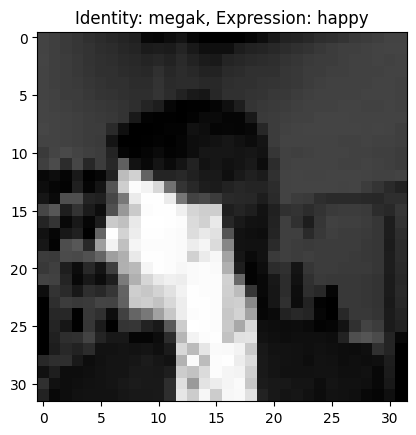

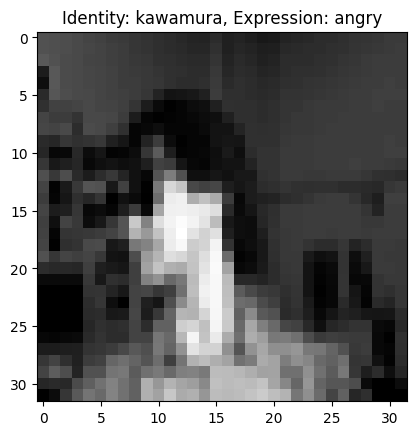

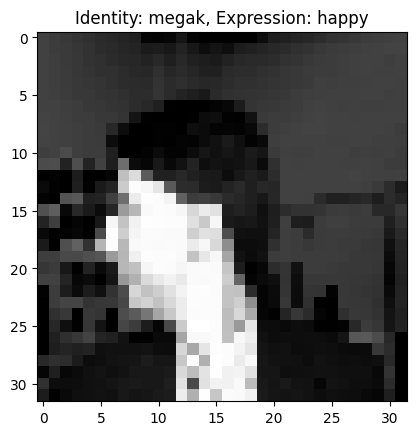

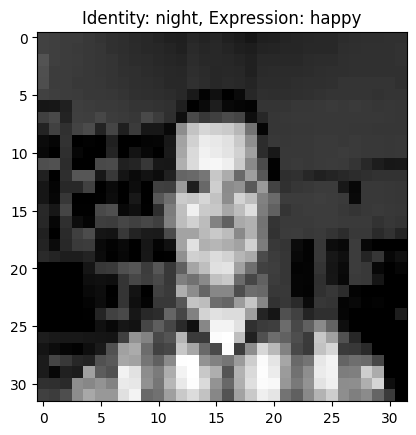

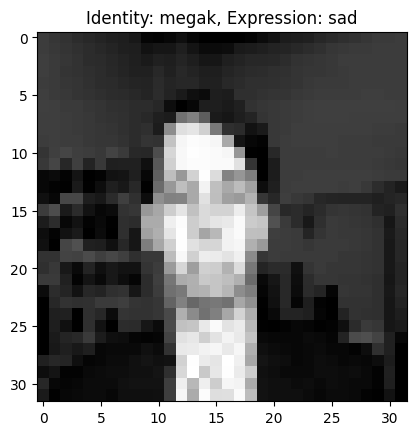

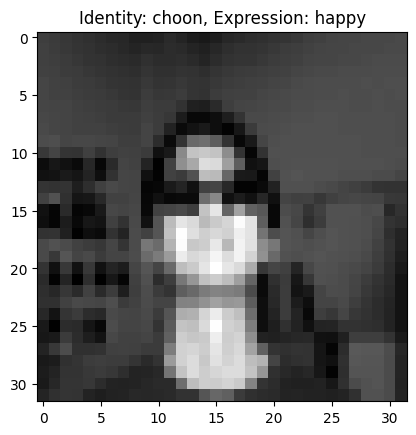

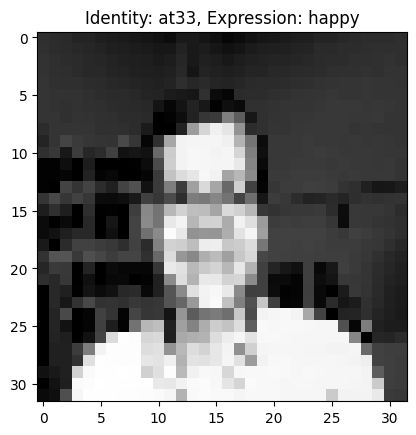

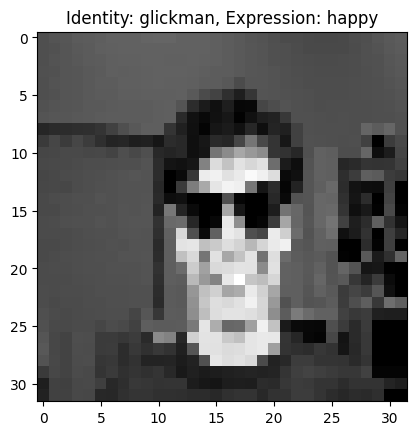

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image along with identity and expression
# Function to show an image along with identity and expression
def show_image_with_labels(img, identity, expression):
    img = img.squeeze().numpy()  # Squeeze to remove the channel dimension
    plt.imshow(img, cmap='gray')  # Specify colormap as 'gray'
    plt.title(f'Identity: {identity}, Expression: {expression}')
    plt.show()


# Get some random training images along with identity and expression labels
images, labels, identity_labels, expression_labels = next(iter(train_loader))

# Show images with labels
for i in range(len(images)):
    show_image_with_labels(images[i], identity_labels[i], expression_labels[i])

Defining a Convolutional Neural Network using LeNet Architecture

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, name=None):
        super(Net, self).__init__()
        if name:
            self.name = name
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Calculate the size after the last pooling layer
        # (adjust based on your actual spatial dimensions)
        self.size_after_last_pooling = 16 * 5 * 5

        self.fc1 = nn.Linear(self.size_after_last_pooling, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)

        # Compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Reshape to match the size after the last pooling layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the LeNet model
lenet_model = Net(name='LeNet5')

# Generate random input for debugging
random_input = torch.randn(8, 1, 32, 32)  # Adjust the batch size and input size if needed

# Pass the input through the model
output = lenet_model(random_input)


LeNet5: total params: 62556


Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.

In [19]:
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer (SGD with momentum)
learning_rate = 0.001
momentum = 0.9
optimizer = optim.SGD(lenet_model.parameters(), lr=learning_rate, momentum=momentum)


Model Training

In [20]:
import time

start = time.time()

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, identity_labels, expression_labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = lenet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}')
            #print('[%d, %5d] loss: %.3f' %
                 # (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

   # Specify the parent directory
parent_directory = '/content/drive/MyDrive/Colab Notebooks/Module 22'

# Create the directory if it doesn't exist
os.makedirs(parent_directory, exist_ok=True)

# Now you can save your model
torch.save(lenet_model.state_dict(), f'{parent_directory}model_epoch_{epoch + 1}.pth')
print('Finished Training')

end = time.time()
print('training time ', end-start)

[1, 100] loss: 0.150
[1, 200] loss: 0.150
[2, 100] loss: 0.150
[2, 200] loss: 0.150
[3, 100] loss: 0.149
[3, 200] loss: 0.149
[4, 100] loss: 0.149
[4, 200] loss: 0.149
[5, 100] loss: 0.148
[5, 200] loss: 0.148
[6, 100] loss: 0.146
[6, 200] loss: 0.144
[7, 100] loss: 0.135
[7, 200] loss: 0.116
[8, 100] loss: 0.089
[8, 200] loss: 0.077
[9, 100] loss: 0.059
[9, 200] loss: 0.049
[10, 100] loss: 0.033
[10, 200] loss: 0.028
Finished Training
training time  13.892086505889893


Now testing the model on test set

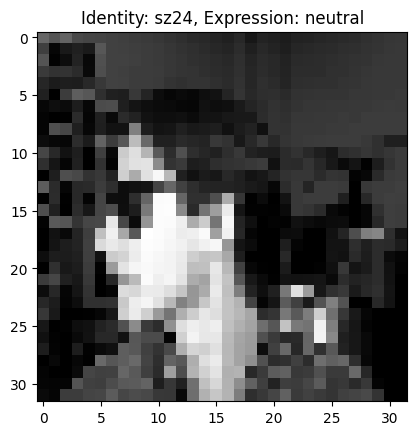

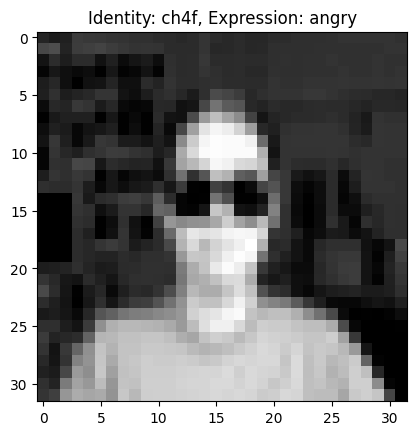

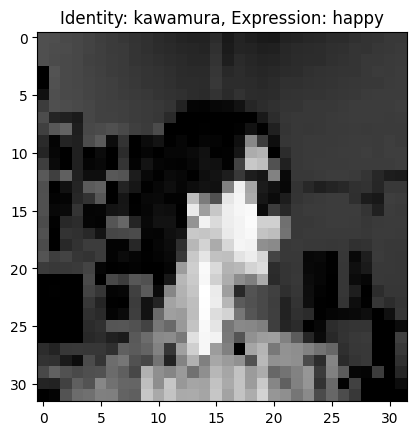

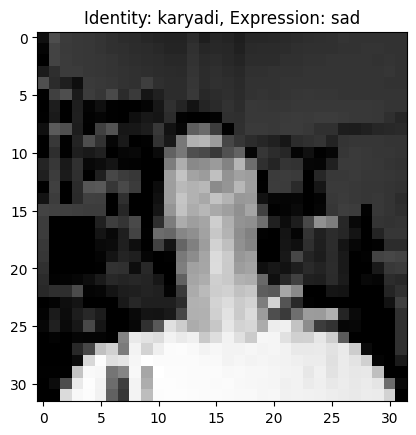

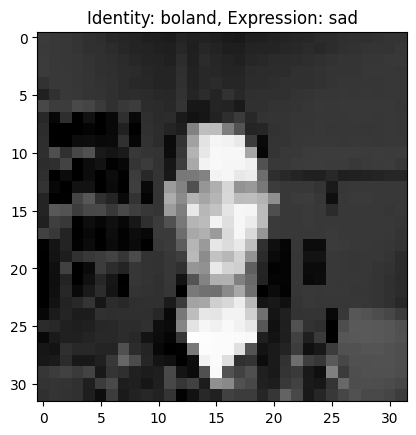

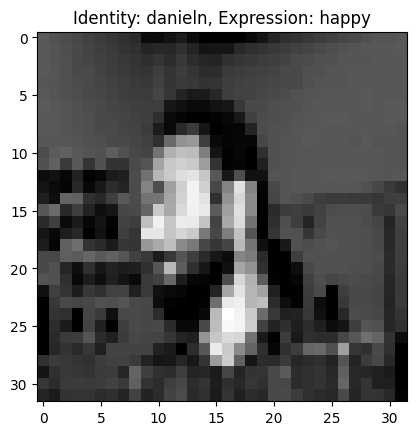

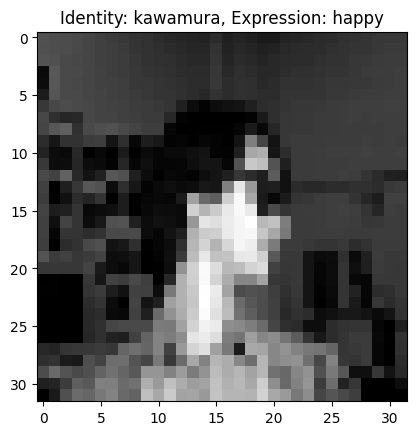

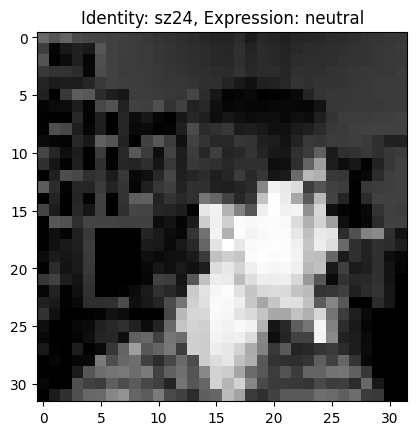

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image along with identity and expression
# Function to show an image along with identity and expression
def show_image_with_labels(img, identity, expression):
    img = img.squeeze().numpy()  # Squeeze to remove the channel dimension
    plt.imshow(img, cmap='gray')  # Specify colormap as 'gray'
    plt.title(f'Identity: {identity}, Expression: {expression}')
    plt.show()


# Get some random training images along with identity and expression labels
images, labels, identity_labels, expression_labels = next(iter(test_loader))

# Show images with labels
for i in range(len(images)):
    show_image_with_labels(images[i], identity_labels[i], expression_labels[i])

Evaluating the model

In [35]:
lenet_model.eval()  # Set the model to evaluation mode

# Move the model to the same device as the input data
lenet_model.to(device)

# Lists to store predictions and ground truth labels
all_predictions = []
all_labels = []

# Iterate through the test loader
with torch.no_grad():  # Disable gradient computation during inference
    for data in test_loader:
        # Unpack the data tuple
        images, labels, identity_labels, expression_labels = data

        # Move data to the same device as the model
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = lenet_model(images)

        # Collect predictions and ground truth labels
        all_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert the lists to NumPy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)


Applying Softmax to the model

In [39]:
# Apply softmax to get probabilities
probabilities = F.softmax(outputs, dim=1)

_, predicted = torch.max(probabilities, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j].item() for j in range(len(images))))


Predicted:     19     7     9    18     5    17     8    14


Obtaining Network Evaluation results

In [40]:
correct = 0
total = 0

lenet_model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels, identity_labels, expression_labels in test_loader:
        # Move the input data to the same device as the model
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = lenet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test set: {:.2f}%'.format(100 * correct / total))

Accuracy on the test set: 86.81%


Printing out the Confusion matrix

In [51]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Initialize variables
all_predictions = []
all_labels = []

lenet_model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient computation during inference
    for images, labels, identity_labels, expression_labels in test_loader:
        # Move data to the same device as the model
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        outputs = lenet_model(images)

        # Collect predictions and ground truth labels
        all_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert the lists to NumPy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Assuming 'classes' is a list containing the real identities
real_identities = ['an2i', 'at33', 'boland', 'bpm', 'ch4f', 'cheyer', 'choon', 'danieln', 'glickman', 'karyadi', 'kawamura', 'kk49', 'megak', 'mitchell', 'night', 'phoebe', 'saavik', 'steffi', 'sz24', 'tammor']

# Map numerical labels to real identities
predicted_identities = [real_identities[i] for i in all_predictions]
actual_identities = [real_identities[i] for i in all_labels]

# Print confusion matrix
conf_matrix = confusion_matrix(actual_identities, predicted_identities, labels=real_identities)
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
class_report = classification_report(actual_identities, predicted_identities, target_names=real_identities)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[96  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 87  0  6  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 61  0  0  0  0  0 12  0  0  0  0  0  0  5  0  0 18  0]
 [ 0  0  0 96  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [12  0  0  0 71  0  0  0  0  0  0  0  0 12  0  0  0  0  0  1]
 [ 0  0  0  0  0 94  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0 92  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 93  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 90  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  1  0  0  0  0  0 86  0  0  0  0  0  0  0  0  0  4]
 [ 0  0  0  0  0  0  0  0  0  0 93  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 95  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0 40  0  0 10 40  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 84  0  0  0  0  0  0]
 [ 0  0  0  0  0 65  0  0  0  0  0  0  0 23  8  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  0  0